In [14]:
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


This time you are trying to optimise another four-dimensional black-box. It corresponds to the yield of a chemical process after processing in some factory. This type of process tends to be unimodal. Try to find the combination of chemicals that maximizes the yield!

In [15]:
def load_initial_data(inputs_file, outputs_file) -> pd.DataFrame:
    X = np.load(inputs_file)
    y = np.load(outputs_file)
    df = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4'])
    df['y'] = y
    return df

df1 = load_initial_data(
    '../initial_data/function_5/initial_inputs.npy',
    '../initial_data/function_5/initial_outputs.npy',
)
df2 = load_initial_data(
    '../initial_data2/function_5/initial_inputs.npy',
    '../initial_data2/function_5/initial_outputs.npy',
)

df = pd.concat([df1, df2], ignore_index=True)

df.head()


,x1,x2,x3,x4,y
0,0.191447,0.038193,0.607418,0.414584,64.443440
1,0.758653,0.536518,0.656000,0.360342,18.301380
2,0.438350,0.804340,0.210245,0.151295,0.112940
3,0.706051,0.534192,0.264243,0.482088,4.210898
4,0.836478,0.193610,0.663893,0.785649,258.370525


In [16]:
import re

df_feedback = pd.read_csv('../initial_data/561_data.csv')

df_feedback = df_feedback[['f5', 'f5_output']]
df_feedback['f5'] = df_feedback['f5'].apply(lambda x: re.findall(r'\d+\.\d*', x))

for i in range(len(df_feedback['f5'].iloc[0])):
    df_feedback[f'x{i+1}'] = df_feedback['f5'].apply(lambda x: float(x[i]))

df_feedback.drop('f5', axis=1, inplace=True)
df_feedback = df_feedback.rename(columns={'f5_output': 'y'})
df_feedback = df_feedback[['x1', 'x2', 'x3', 'x4', 'y']]

df = pd.concat([df, df_feedback], ignore_index=True)
df.describe()

,x1,x2,x3,x4,y
count,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.471438,0.549522,0.478822,0.457116,336.437635
std,0.279593,0.306925,0.288635,0.317226,586.590315
min,0.000000,0.000000,0.000000,0.000000,0.112940
25%,0.215760,0.319560,0.293856,0.169661,21.362234
50%,0.460971,0.628347,0.450411,0.428615,79.729130
75%,0.680462,0.818720,0.689198,0.761044,302.166862
max,0.999999,0.999999,0.954017,0.996248,2136.952984


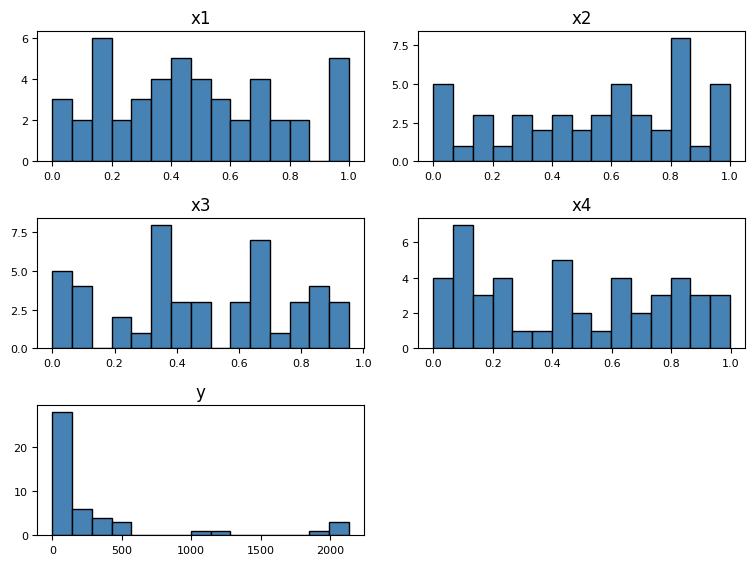

In [17]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [18]:
def analyse_param(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot histogram
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Frequency")
    axes[0].hist(df[x], bins=15, color='steelblue', edgecolor='black', linewidth=1.0)

    # Plot density
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Frequency")
    sns.kdeplot(df[x], ax=axes[1], color='steelblue', shade=True, legend=False)

    # Plot scatter
    axes[2].set_xlabel(x)
    axes[2].set_ylabel(y)
    axes[2].scatter(df[x], df[y], s=30, edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()


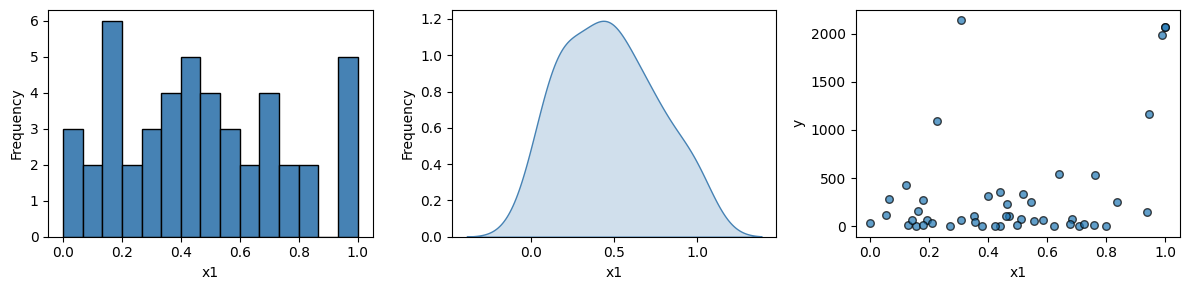

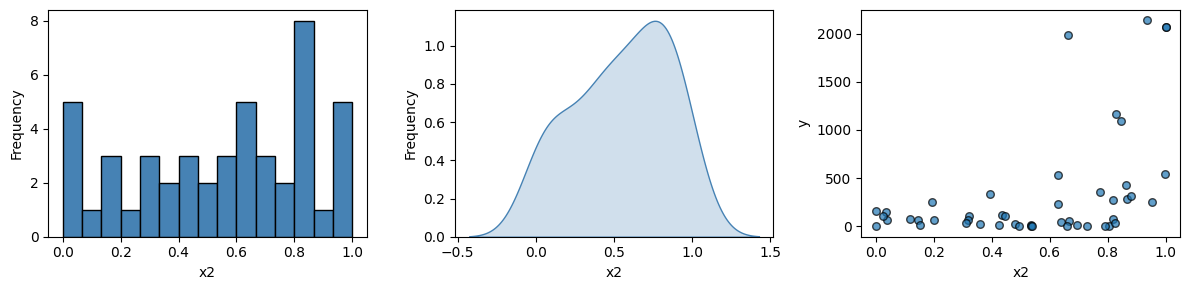

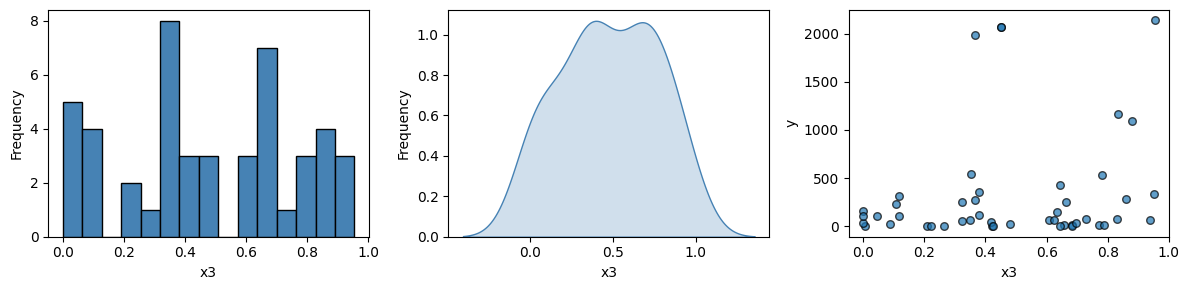

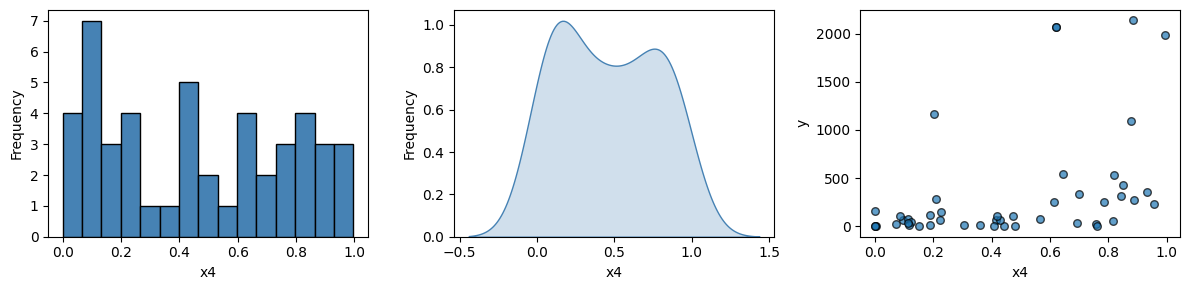

In [19]:
analyse_param(df, 'x1', 'y')
analyse_param(df, 'x2', 'y')
analyse_param(df, 'x3', 'y')
analyse_param(df, 'x4', 'y')

In [20]:
def analyse_corr_to_y(df):
    # Plot correlation to y
    corr = df.corr()
    sns.heatmap(corr[['y']], annot=True, cmap='coolwarm')

    # Analyse correlation of variables to y
    g = sns.PairGrid(df, y_vars=["y"], x_vars=["x1", "x2", "x3", "x4"])
    g.map(sns.regplot, color='steelblue')

    plt.tight_layout()
    plt.show()

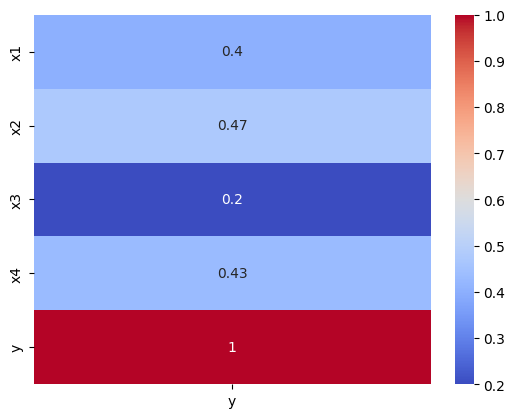

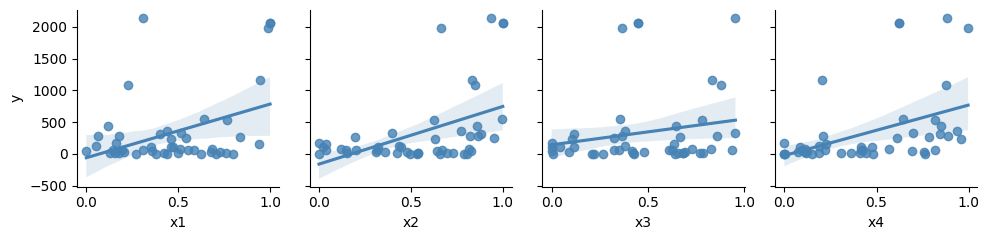

In [21]:
analyse_corr_to_y(df)

In [22]:
def pairwise_relationship(df):
    sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'black'})
    plt.tight_layout()
    plt.show()

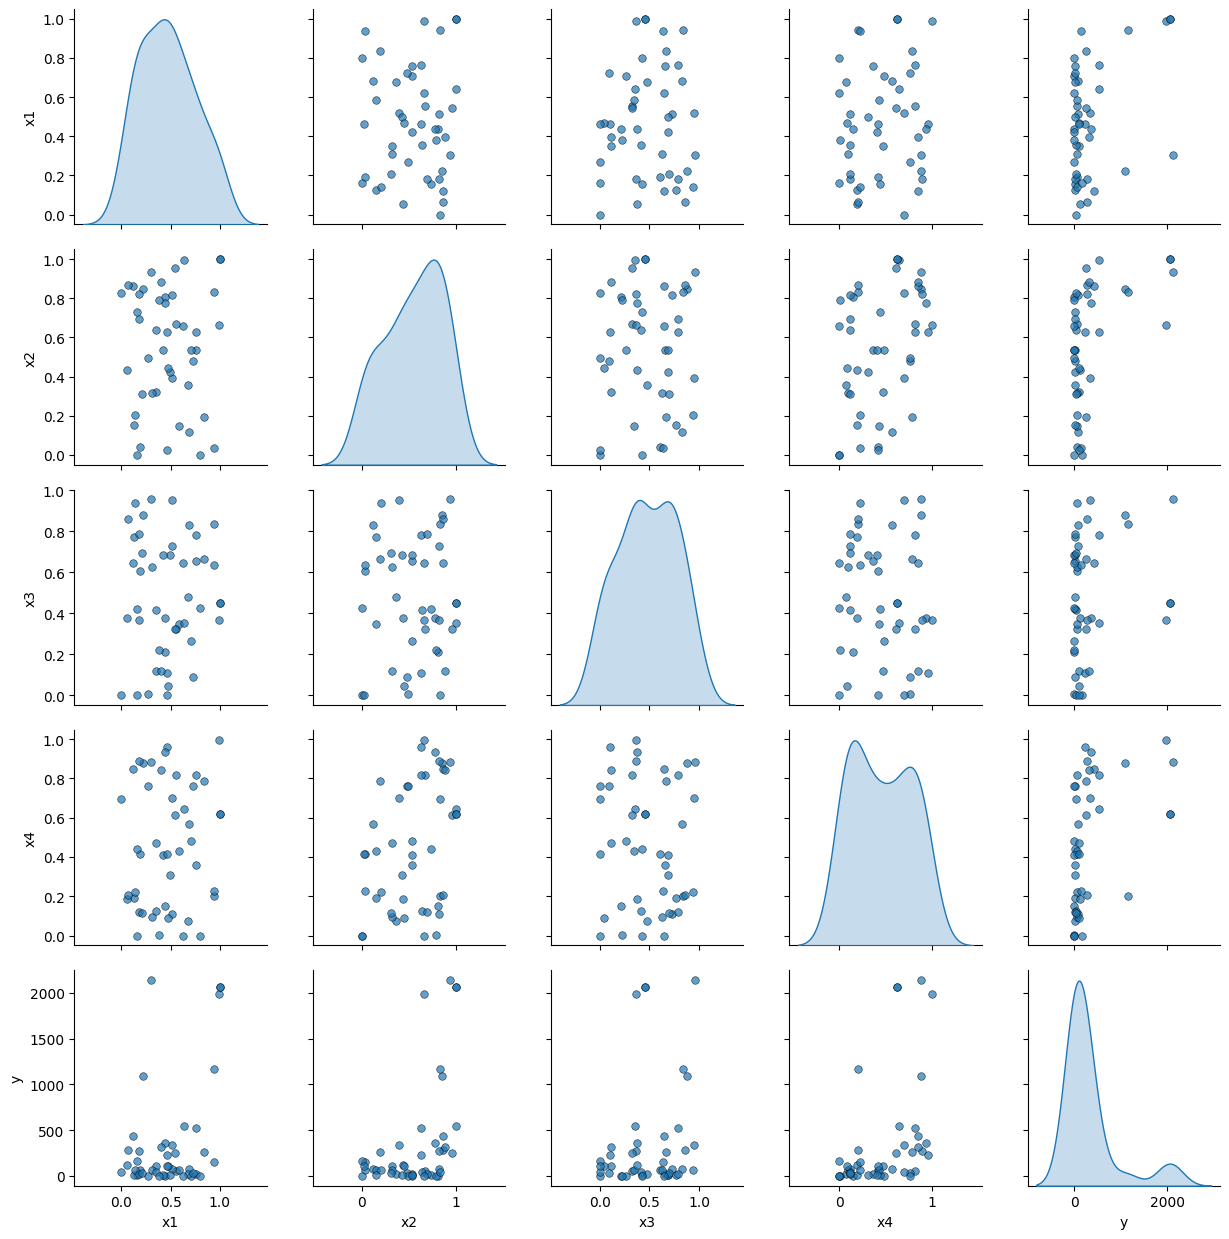

In [23]:
pairwise_relationship(df)

In [24]:
def objective_fn(x):
    return -(np.array([x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3]]).T)

objective = GPyOpt.core.task.SingleObjective(objective_fn)

space = GPyOpt.Design_space(
    space=[{'name': 'x1', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x4', 'type': 'continuous', 'domain': (0, 0.999999)}]
)

gp_kernel = GPy.kern.RBF(
    input_dim=4,
    variance=1.0,
    lengthscale=1.0,
    ARD=True
)

model = GPyOpt.models.GPModel(
    exact_feval=False,
    optimize_restarts=5,
    verbose=False,
    kernel=gp_kernel
)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, acquisition_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator,
    X_init=df[['x1', 'x2', 'x3', 'x4']].values,
    Y_init=df['y'].values.reshape(-1, 1),
    de_duplication=True
)

In [25]:
bo.plot_acquisition()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
x_next = bo.suggest_next_locations()
print(f"next_query: {'-'.join(['%.6f' % x for x in x_next[0]])}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
